# Try learning ODE instead of trajectory

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
import embed_dynamics
import sys, importlib
from dynamics_methods import *
from embedding_methods import *
from NN_transfer import NN_ODE_traj
from importlib import reload
%load_ext tensorboard

In [2]:
t0 = 0
t1 = 100 
dt = 0.01 
ts_steps = np.arange(t0, t1, dt)
u_func_list = [
    # We don't need input here. Just place a placeholder.
    lambda t : 0*t, 
    lambda t : 0*t
]

init_list = [ None, np.array([0.1,0.2,0.3,0,0,15,-20])+np.random.randn(7)*0.2 ]
u_names = ['.']
pred=1

cross_sys = embed_dynamics.CoupledRosslerFullState(t0=t0, tf=t1, dt=dt, pred=pred, params=[0.925, 0.012])
sys_list = [cross_sys]
sys_names = ['Coupled Rossler full state']

# Make some data generation input functions
for syst in sys_list:
    syst.add_u_func( u_func_list, init_list )
# A quick and dirty way to add another "test set" that uses longer time
for syst in sys_list:
    syst.add_u_func( u_func_list[0], init_list[0], (t0, t1*3, dt) )
for syst in sys_list:
    syst.data_generator()

u_names=['train0','test1','train_long']
out_names=['S1','S2','S3','S4','S5','S6','S7']

<Figure size 432x288 with 0 Axes>

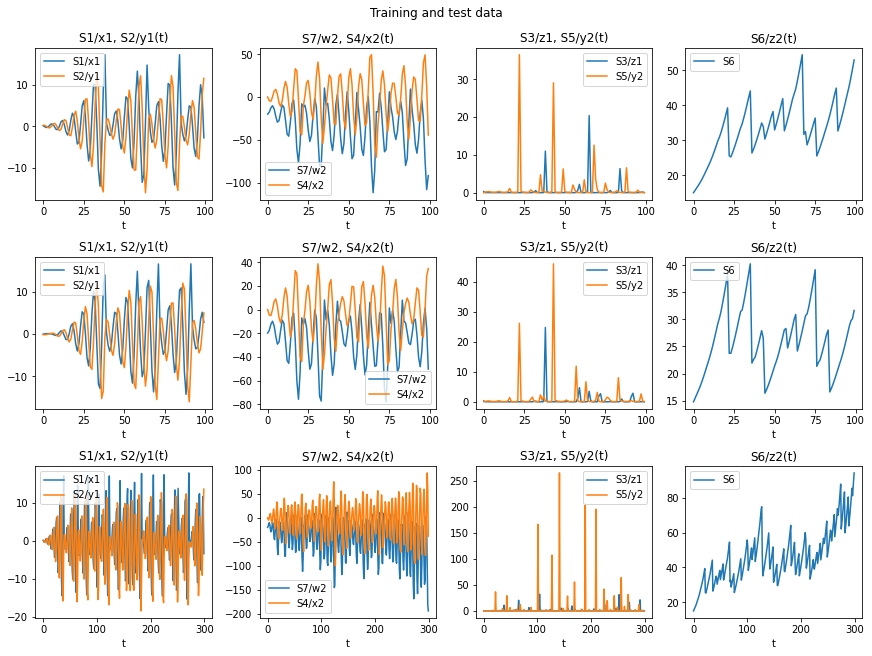

In [6]:
fig,axs = cross_sys.plot_dataset(title='Training and test data', plot_skip_rate=100)

In [308]:
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *
# importlib.reload(sys.modules["NN_ODE"])
# from NN_ODE import *

# To be extra safe, run the reloading code for two times
reload(networks)
reload(system_dynamics)
reload(embed_dynamics)
importlib.reload(sys.modules["dynamics_methods"])
from dynamics_methods import *
importlib.reload(sys.modules["embedding_methods"])
from embedding_methods import *
# importlib.reload(sys.modules["NN_ODE"])
# from NN_ODE import *

# First, train a model that learns the ODE with loss on the derivative values

In [3]:
# Test out the chosen delay value. Set up nets.
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
activation = 'tanh'
# activation = 'sigmoid' # 'tanh' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
# input_masks = [ [4,7] ] # Reminder: index 0 is time. Index 1 is first state.
input_masks = [ [1,4,7] ]
Nlayer = 2
Nneuron = 50
de = 6
delay_int = 50

net_listO = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listO.append(
        embed_dynamics.NN_ODE_diff(
            sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, pred=0, de=de, delay_int=delay_int, no_normalize=False #True
        )
    )
net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listO:
    nn.construct()


In [4]:
# Train models. 
Epoch = 100
for nn in net_listO:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:87: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


Train on 9750 samples
Epoch 1/100
9750/9750 [==============================] - 1s 128us/sample - loss: 0.9005
Epoch 2/100
9750/9750 [==============================] - 0s 36us/sample - loss: 0.7204
Epoch 3/100
9750/9750 [==============================] - 0s 36us/sample - loss: 0.6299
Epoch 4/100
9750/9750 [==============================] - 0s 38us/sample - loss: 0.56690s - loss: 0.567
Epoch 5/100
9750/9750 [==============================] - 0s 48us/sample - loss: 0.5255
Epoch 6/100
9750/9750 [==============================] - 0s 40us/sample - loss: 0.4927
Epoch 7/100
9750/9750 [==============================] - 1s 54us/sample - loss: 0.4716
Epoch 8/100
9750/9750 [==============================] - 0s 44us/sample - loss: 0.4528
Epoch 9/100
9750/9750 [==============================] - 0s 46us/sample - loss: 0.4368
Epoch 10/100
9750/9750 [==============================] - 0s 38us/sample - loss: 0.4240
Epoch 11/100
9750/9750 [==============================] - 0s 35us/sample - loss: 0.4097
Ep

In [8]:
net_listO[0].no_normalize

False

In [5]:
# Plotting helper function...
# This one is modified to suite the ODE approach, and is different from those in other notebooks. 
def plot_tests(test_inds, net_list, net_inds, out_list, net_names, u_names, out_names,
               datatype='traj', log_mode=False, plot_skip_rate=1, title='', maxtime=None):
    # Arguments:
    # test_inds: indices of test dataset to be plotted
    # net_list : neural nets (containing their own dynamics). Don't pass one in if its dynamics size is weird.
    # out_list : indices of output values you want to see. This assumes those indices apply to all dynamics.
    # datatype : Type of data that's going to be plotted
    # log_mode : whether the plots are in log scale or not
    plt.clf()
    results_list = []
    results_traj = []
    correct_traj = []
    for nn in net_list:
        tempres = nn.test(inds=test_inds,squeeze=False)
        results_list.append(tempres[0])
        results_traj.append(tempres[1])
        correct_traj.append(tempres[2])
    if log_mode:
        logtxt = 'log '
    else:
        logtxt = ''
    
    # datatype decides what appears on the plot
    
    Noutput = len(out_list)
    Nrow = (len(net_inds)) * Noutput # Leave the final 2 rows for aggregated plots
    Ncol = len(test_inds)
    fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (max(15,Ncol*4),Nrow*3), squeeze=False)
#     figt,axst = plt.subplots(Noutput, Ncol, constrained_layout=True, figsize = (Ncol*4,Noutput*4), squeeze=False)
    
    for j in range(len(test_inds)):
        # For each test dataset (each column), plot all models' reactions
        jj = test_inds[j]
        
        # For each network, find its prediction and plot corresponding outputs
        for n in range(len(net_inds)):
            nn = net_inds[n]
            # Find its time series. 
            time_series = np.squeeze(results_list[nn][3][jj])
            # Above: [nn] - Take the nn-th network's result; [3] - The 4th element in result is Timeset;
            #        [jj] - Take the jj-th test run's result; 
            
            # Find the correct thing that we want to plot.
#             correct_traj_stripped = correct_traj[nn][jj][nn.dynamics.stateind:nn.dynamics.inputind]
            result2 = correct_traj[nn][jj]
            if datatype == 'l2':
                result = np.square(results_traj[nn][jj] - correct_traj[nn][jj])
            elif datatype == 'l1':
                result = np.abs(results_traj[nn][jj] - correct_traj[nn][jj])
            elif datatype == 'ode':
                result = np.squeeze(results_list[nn][0][jj]).T
                result2 = np.squeeze(results_list[nn][1][jj]).T
            elif datatype == 'training output':
                result = np.squeeze(net_list[nn].Outputset[jj]).T # But this is actually the derivatives of training set
#             elif datatype == 'state and deriv':
#                 result = 
            # Don't need to do anything else when it's 'traj'.
            else:
                result = results_traj[nn][jj]
            if log_mode:
                result = np.log(result)
            
            # Make individual plots for each output, where the indexing fun begins
            for i in range(Noutput):
                ii = out_list[i]
                make_axs_plot(
                    axs = axs[n + len(net_inds)*i][j], time = time_series, data = result[ii],#data = result[:,ii],
                    title = logtxt+datatype+' of '+out_names[i]+'\n for '+net_names[nn]+'\n on input '+u_names[jj],
                    datatype = datatype, data2 = result2[ii], 
                    leglist = [net_names[nn], 'True value'], skip = plot_skip_rate, maxtime=maxtime
                )
    fig.suptitle(title)
    return fig, axs, results_list

def make_axs_plot(axs, time, data, title, datatype, data2=None, leglist=[], skip=1, maxtime=None):
    if maxtime is None:
        maxtime = len(time)
    else:
        maxtime = int(maxtime)
    axs.plot(time[:maxtime:skip], data[:maxtime:skip])
#     print(time.shape, data.shape, data2.shape)
    axs.set_title(title)
    axs.set_xlabel('t')
    if datatype in ['traj', 'ode']:
        axs.plot(time[:maxtime:skip], data2[:maxtime:skip])
        axs.legend(leglist)
    return axs

Dimensions: Outputset = (9989, 7, 1), results = (9989, 7, 1)
Dimensions: Outputset = (9983, 7, 1), results = (9983, 7, 1)


<Figure size 432x288 with 0 Axes>

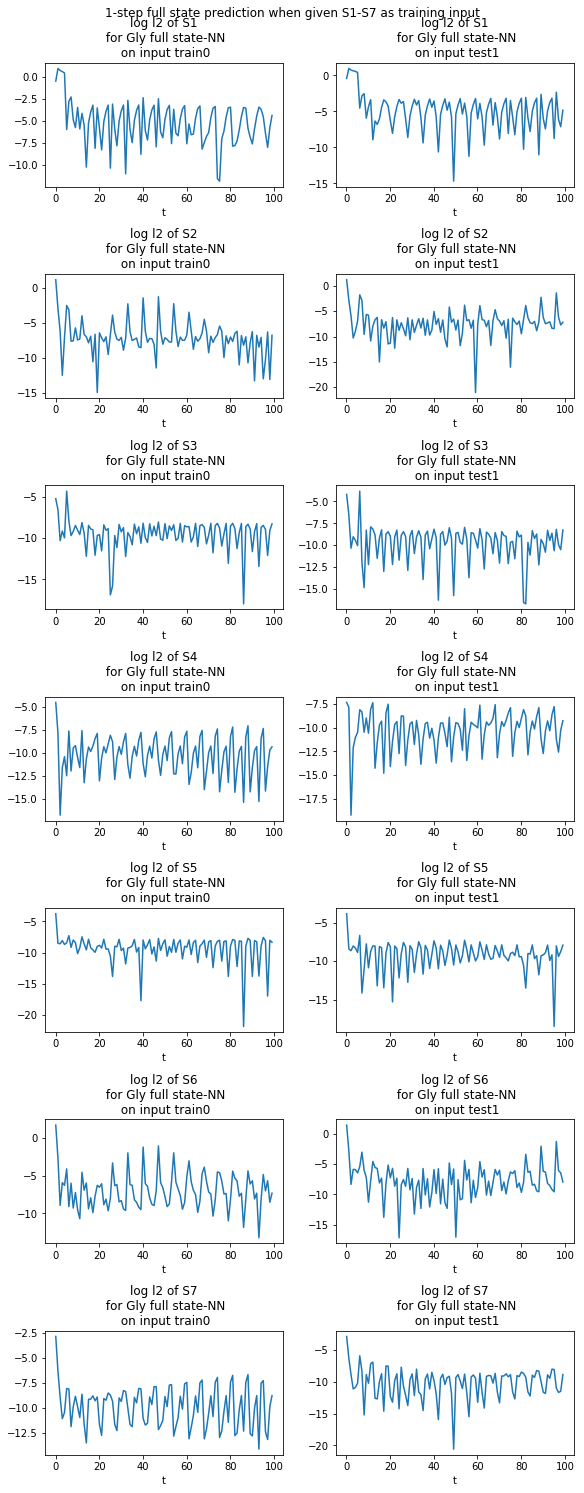

In [37]:
fig, axs, results = plot_tests( test_inds=[0,1], net_list=net_listO, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='l2', log_mode=True, plot_skip_rate=100, 
                       title='Predict S1-S7 from S4 and S7\n' )

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:87: RuntimeWarning: invalid value encountered in true_divide
  #     print('Turned data back to its original shape {0} and finishing the method.'.format(data.shape))


<Figure size 432x288 with 0 Axes>

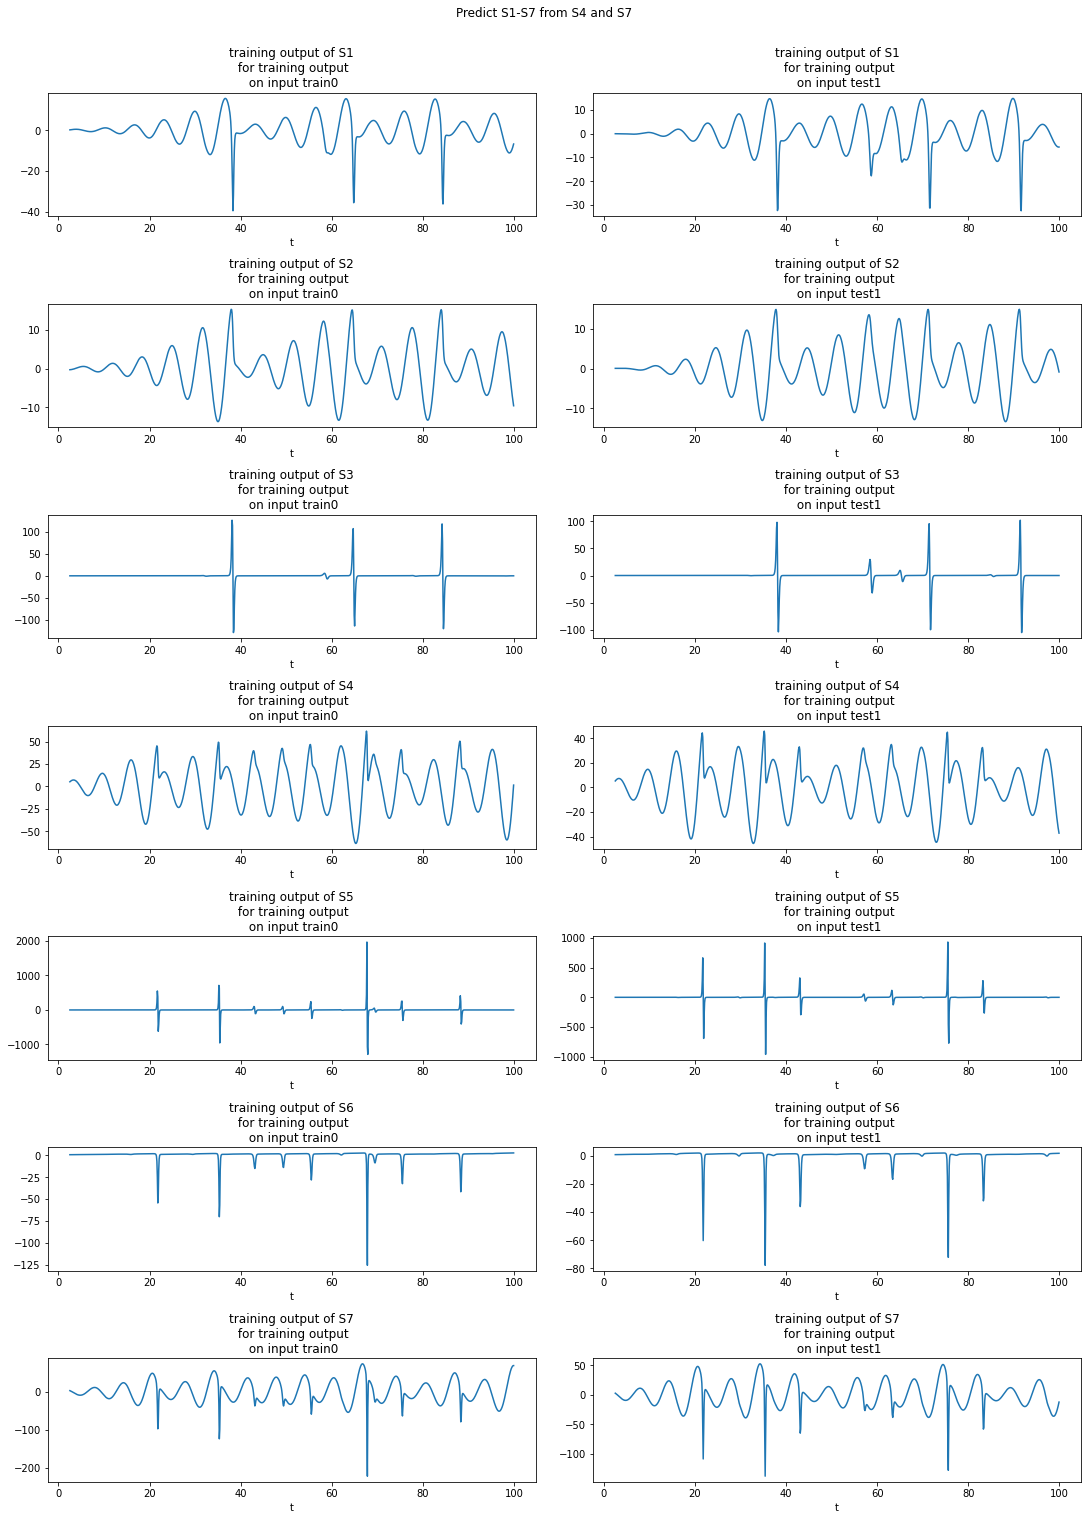

In [286]:
fig, axs, results = plot_tests( test_inds=[0,1], net_list=net_listO, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=['training output'], u_names=u_names, out_names=out_names,
                       datatype='training output', log_mode=False, plot_skip_rate=10, 
                       title='Predict S1-S7 from S4 and S7\n' )
# blue looks like orange's derivative

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:87: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


<Figure size 432x288 with 0 Axes>

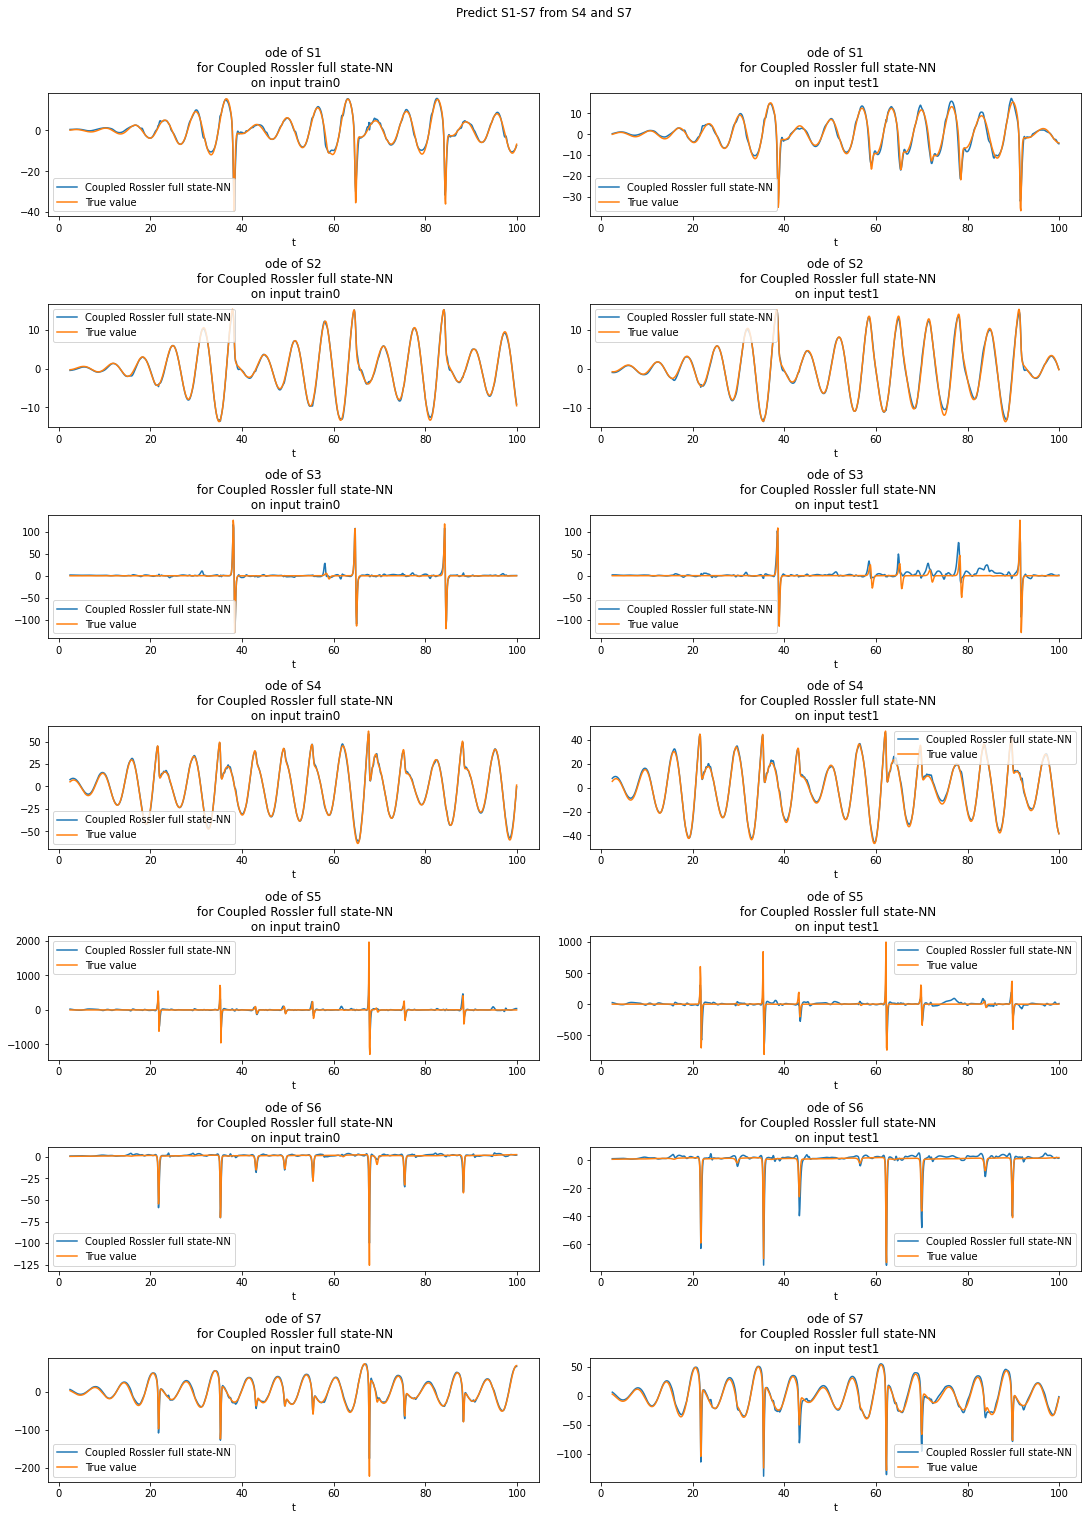

In [6]:
fig, axs, results = plot_tests( test_inds=[0,1], net_list=net_listO, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='ode', log_mode=False, plot_skip_rate=10, 
                       title='Predict S1-S7 from S4 and S7\n' )
# Orange is true deriv. Blue might fit better with more observables.

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:87: RuntimeWarning: invalid value encountered in true_divide
  data[i] = (data[i] - params[0][i]) / params[1][i]


<Figure size 432x288 with 0 Axes>

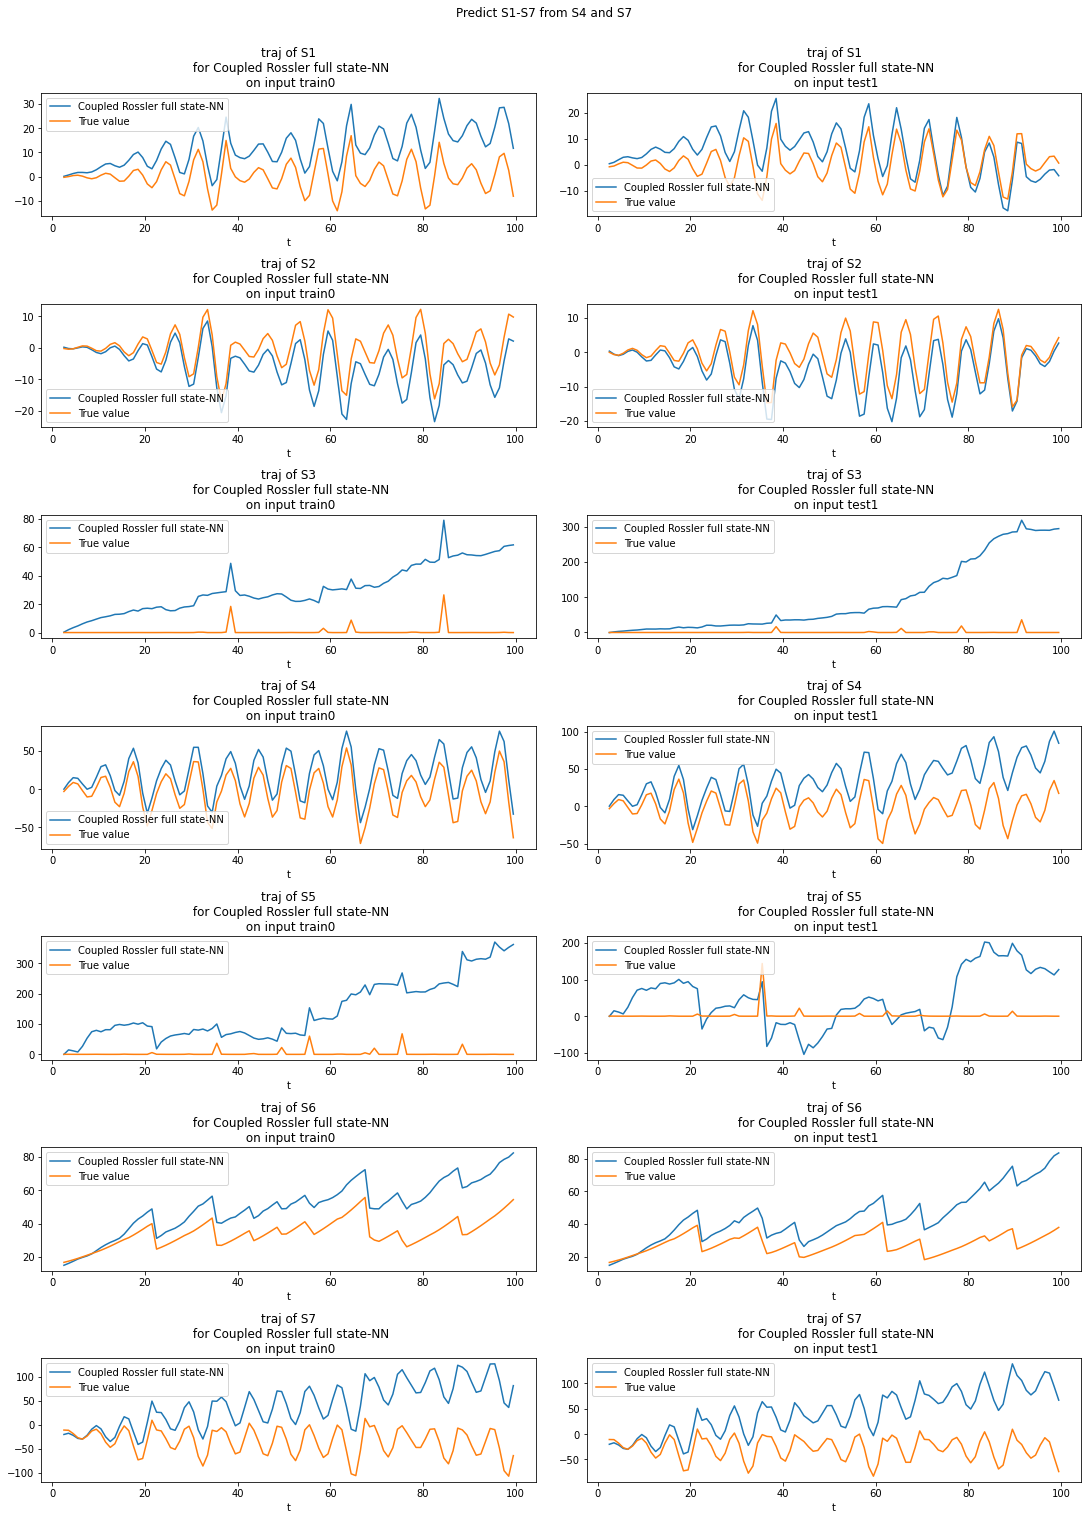

In [7]:
fig, axs, results = plot_tests( test_inds=[0,1], net_list=net_listO, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=100, #maxtime=20/dt,
                       title='Predict S1-S7 from S4 and S7\n' )

axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 10000).
The parameters have size (4,), so we resized the data into (2, 10000) for computation.
Turned data back to its original shape (2, 10000) and finishing the method.
axis 0 is the main axis. There are 2 variables along it. Whole data size is (2, 30000).
The parameters have size (4,), so we resized the data into (2, 30000) for computation.
Turned data back to its original shape (2, 30000) and finishing the method.
Dimensions: Outputset = (9808, 7, 1), results = (9808, 7, 1)


<Figure size 432x288 with 0 Axes>

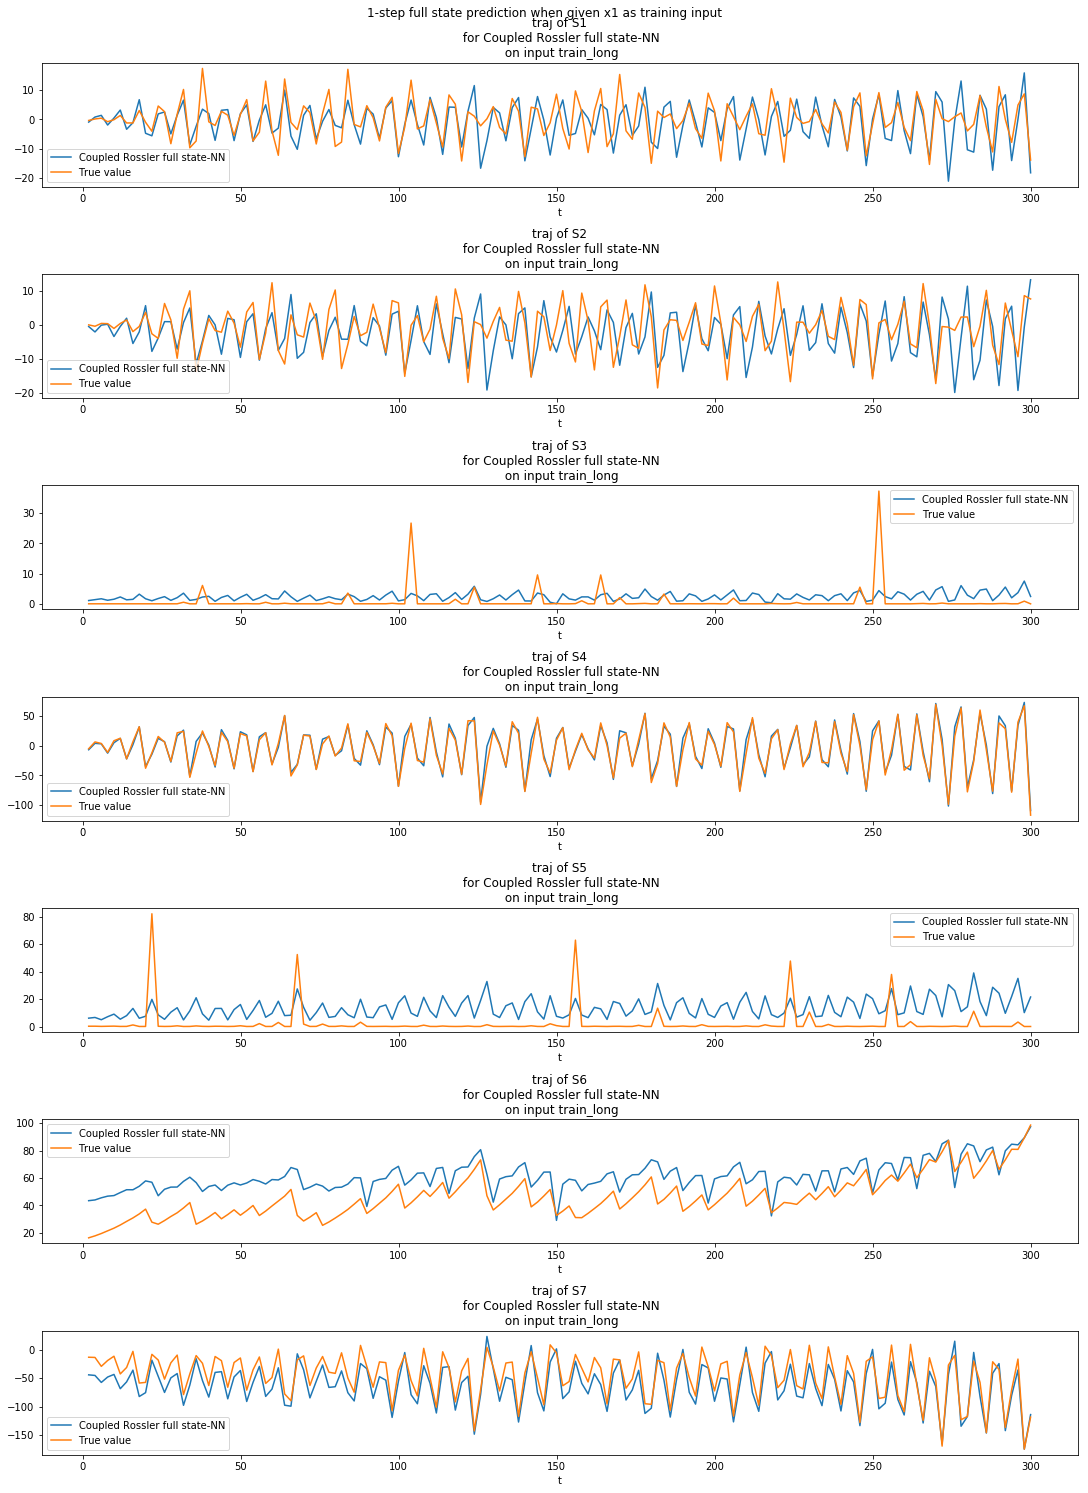

In [233]:
# Plots the test dataset with very long time range
fig, axs = plot_tests( test_inds=[2], net_list=net_listO, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=200, 
                       title='1-step full state prediction when given x1 as training input\n' )
# fig, axs = plot_tests( test_inds=[2], net_list=net_listO, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
#                        net_names=net_names, u_names=u_names, out_names=out_names,
#                        datatype='l2', log_mode=True, plot_skip_rate=500, 
#                        title='1-step full state prediction when given S1-S3 as training input\n' )

# now try to train another model with loss from trajectory

In [36]:
net_listO[0].model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 357       
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 1)              0         
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [172]:
net_listT[0].model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 18)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 357       
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 1)              0         
_________________________________________________________________
reshape_79 (Reshape)         (None, 7)                 0         
_________________________________________________________________
dense_85 (Dense)             (None, 50)                4

In [87]:
aaa = np.arange(18).reshape(2,3,3)
aaa[[0],0:2,:].shape
type(aaa)

numpy.ndarray

In [91]:
bbb=np.array([[1,2,3],[4,5,6],[7,8,9]])
type(bbb)

numpy.ndarray

In [67]:
# net_listT[0].model.predict(np.arange(18).reshape(1,3,6))
net_listT[0].model(np.arange(18).reshape(3,6))

InvalidArgumentError: Input to reshape is a tensor with 18 values, but the requested shape has 54 [Op:Reshape]

In [173]:
importlib.reload(sys.modules["NN_transfer"])
from NN_transfer import *

In [174]:
net_listT = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listT.append(
        NN_ODE_traj(
            sys_list[i], input_masks[i], net_listO[i].model, seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, pred=0, de=de, delay_int=delay_int, no_normalize=False,
            pred_frame_len=100, pred_frame_weight_func=None, pred_frame_interv=1
        )
    )
net_namesT = [ sys_names[i]+'-transfered-NN' for i in range(len(sys_list)) ]

# Construct models
for nn in net_listT:
    nn.construct()


In [175]:
# Train models. 
Epoch = 10
for nn in net_listT:
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 8157) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 1449) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 4971) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 9586) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 4793) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -  (0, 0, 7029) (7, 100) (9, 100)
training loop - Inputset and Outputset size -  (9750, 9, 6) (9750, 7, 1)
deriv2traj -  (7, 100) (100,) (7, 1)
training loop -

KeyboardInterrupt: 

# Everything below is debugging

In [144]:
np.dot( np.array([1,2,3]), np.arange(18).reshape(6,3) )

ValueError: shapes (3,) and (6,3) not aligned: 3 (dim 0) != 6 (dim 0)

In [176]:
aaaa = tf.Variable(tf.zeros(4))

In [177]:
aaaa

<tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>

In [178]:
aaaa = aaaa[0:2].assign(tf.ones(2))

In [179]:
aaaa

<tf.Variable 'UnreadVariable' shape=(4,) dtype=float32, numpy=array([1., 1., 0., 0.], dtype=float32)>

In [181]:
bb = tf.convert_to_tensor(10)

In [182]:
bb

<tf.Tensor: id=263510, shape=(), dtype=int32, numpy=10>

In [186]:
dir(bb)

['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',
 '_as_node_def_i

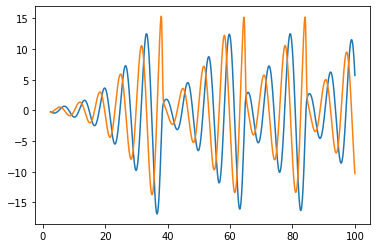

In [263]:
# Time in training data
time = np.squeeze(net_listO[0].Inputset[0][:,[0],-1])
# training input
traj = np.squeeze(net_listO[0].Inputset[0][:, 1:8, -1]).T # Inputset original shape: (9900, 9, 3)
# training derivatives
deriv = np.squeeze(net_listO[0].Outputset[0]).T

plt.plot(time, np.vstack((traj[[1]], deriv[[1]])).T)

In [264]:
x0 = traj[:,[0]]
traj_pred = integrate.cumtrapz( deriv, x=time, axis=1 ) + x0

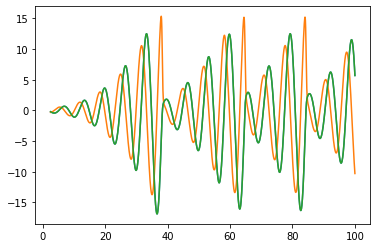

In [265]:
plt.plot(time, np.vstack((traj[[1]], deriv[[1]], np.hstack((x0, traj_pred))[[1]] )).T)

In [153]:
# Add some noise to the derivatives and see what happens
dx1 = deriv + 0.1*np.random.randn(*deriv.shape) # Use * to unpack the shape tuple
traj_pred1 = integrate.cumtrapz( dx1, x=time, axis=1 ) + x0

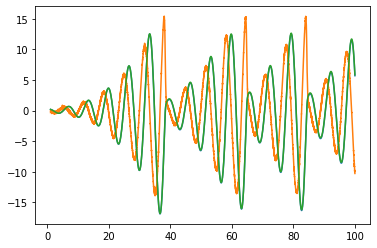

In [154]:
plt.plot(time, np.vstack((traj[[1]], dx1[[1]], np.hstack((x0, traj_pred1))[[1]] )).T)

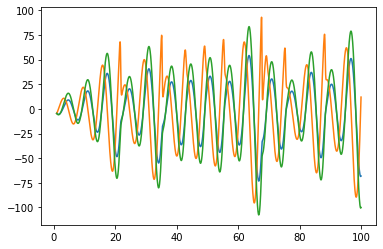

In [166]:
# Add some more noise to the derivatives and see what happens
ind = 3
# dx2 = deriv * (1 + 0.5*np.random.randn(*deriv.shape)) # Use * to unpack the shape tuple
dx2 = deriv * 1.5
traj_pred2 = integrate.cumtrapz( dx2, x=time, axis=1 ) + x0
plt.plot(time, np.vstack((traj[[ind]], dx2[[ind]], np.hstack((x0, traj_pred2))[[ind]] )).T)

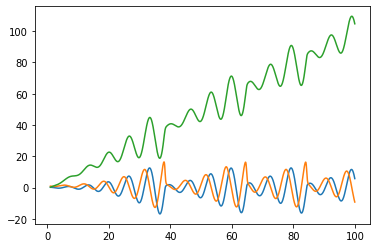

In [170]:
# Force-feed some more noise to the derivatives and see what happens
ind = 1
dx3 = deriv + 0.01
traj_pred3 = integrate.cumtrapz( dx3, x=time, axis=1 ) + x0
plt.plot(time, np.vstack((traj[[ind]], dx3[[ind]], np.hstack((x0, traj_pred3))[[ind]] )).T)

In [294]:
jj = 0 #test_inds[j]
# Check the predicted derivatives
results_list = []
results_traj = []
correct_traj = []
for nnw in net_listO:
    tempres = nnw.test(inds=[jj],squeeze=False)
    results_list.append(tempres[0])
    results_traj.append(tempres[1])
    correct_traj.append(tempres[2])
j = 0
n = 0
nn = 0
time_series = np.squeeze(results_list[nn][3][jj])

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:87: RuntimeWarning: invalid value encountered in true_divide
  #     print('Turned data back to its original shape {0} and finishing the method.'.format(data.shape))


In [298]:
results_list[nn][3][jj]#[0]#,-res_deriv.shape[1]:]

array([ 2.5 ,  2.51,  2.52, ..., 99.97, 99.98, 99.99])

In [299]:
res = results_list[nn][0][0]

In [303]:
res_deriv = res.squeeze().reshape(7,-1)
res_deriv.shape

(7, 9750)

In [307]:
res_deriv, res.squeeze().T

(array([[ 5.0316758e-02, -1.7076367e-01,  4.2472807e-01, ...,
          2.6032526e+01, -1.0303973e+01,  1.0781804e+00],
        [-2.2091766e+01,  2.8073778e+00, -1.1101739e-01, ...,
          2.6303378e-01,  2.1858889e+01, -4.1700802e+00],
        [ 1.8438706e+00, -3.3231567e+01,  8.4024210e+00, ...,
          3.3072715e+00, -2.3844843e-01,  9.2861786e+00],
        ...,
        [-2.4009064e+01, -1.2520218e+00,  2.3249278e+00, ...,
         -1.1125350e+01, -6.4998412e+00,  1.9626205e+00],
        [ 7.1123856e-01, -3.1680214e+01, -4.4812682e-01, ...,
          1.6954606e+00,  2.9887306e+01, -2.7803528e+00],
        [-1.6352898e+00,  1.4232284e+00, -3.7048885e+01, ...,
         -2.2559443e+00,  2.5392411e+00,  6.5645035e+01]], dtype=float32),
 array([[ 5.0316758e-02,  5.4929309e-02,  5.9489273e-02, ...,
         -5.2391248e+00, -5.1347346e+00, -5.0296459e+00],
        [-1.7076367e-01, -1.6976316e-01, -1.6871813e-01, ...,
         -1.0150500e+01, -1.0218504e+01, -1.0285686e+01],
        [ 

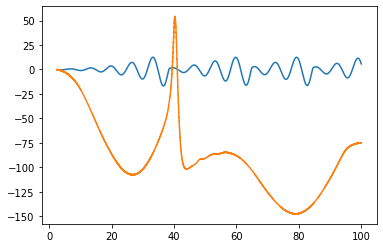

In [305]:
traj_result = integrate.cumtrapz( res_deriv, x=time_series, axis=1 ) + x0
plt.plot(time_series, np.vstack((traj[[ind]], np.hstack((x0, traj_result))[ind] )).T)

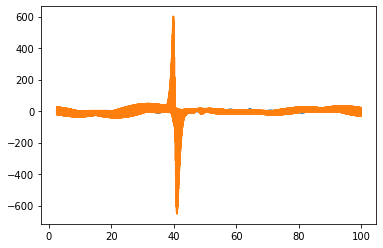

In [306]:
plt.plot(time_series, np.vstack((deriv[[ind]], res_deriv[[ind]] )).T)

In [202]:

# Above: [nn] - Take the nn-th network's result; [3] - The 4th element in result is Timeset;
#        [jj] - Take the jj-th test run's result; 

# result2 = correct_traj[nn][jj]
# # if datatype == 'ode':
# result = np.squeeze(results_list[nn][0][jj]).T
# result2 = np.squeeze(results_list[nn][1][jj]).T
# # else:
# result = results_traj[nn][jj]


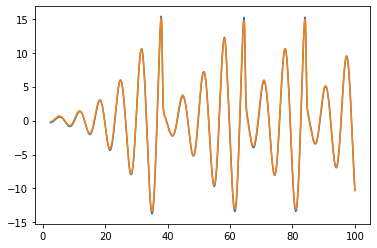

In [295]:
ind = 1
# Compare the derivatives first
dxp = np.squeeze(results_list[nn][0][jj]).T
deriv = np.squeeze(results_list[nn][1][jj]).T
plt.plot(time_series, np.vstack((deriv[[ind]], dxp[[ind]] )).T)

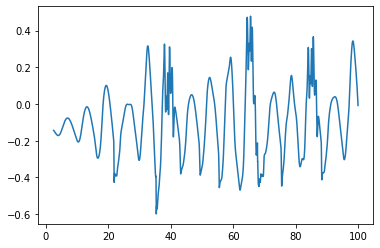

In [283]:
plt.plot(time_series, (deriv[[ind]] - dxp[[ind]]).T)

In [258]:
np.mean((deriv[[ind]] - dxp[[ind]]) * np.abs(deriv[[ind]] - dxp[[ind]]))

-0.014085037623536162

(7, 9900)
(7, 9900)
(9900,)


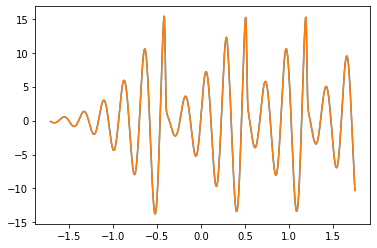

In [236]:
# This cell is just to make sure true derivatives is obtained in the correct way
print(np.squeeze(net_listO[0].Outputset[0]).T.shape)
print(deriv.shape)
print(time_series.shape)
plt.plot(time_series, np.vstack((np.squeeze(net_listO[0].Outputset[0]).T[[1]], deriv[[1]])).T)

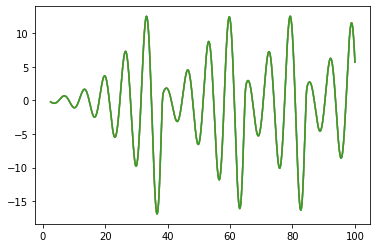

In [284]:
# This cell makes sure the integration thinks the same...
timme = np.squeeze(net_listO[0].Inputset[0][:,[0],-1])
traj_predr = integrate.cumtrapz( deriv, x=time_series, axis=1 ) + x0
traj_predt = integrate.cumtrapz( deriv, x=timme, axis=1 ) + x0
# traj = np.squeeze(net_listO[0].Inputset[0][:, 1:8, -1]).T
ind = 1
plt.plot(time_series, np.vstack((traj[[ind]], np.hstack((x0, traj_predr))[[ind]], np.hstack((x0, traj_predt))[[ind]] )).T)

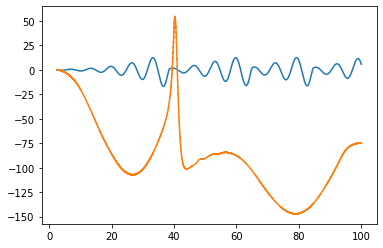

In [292]:
plt.plot(time_series, np.vstack((traj[[ind]], results_traj[nn][jj][ind] )).T)

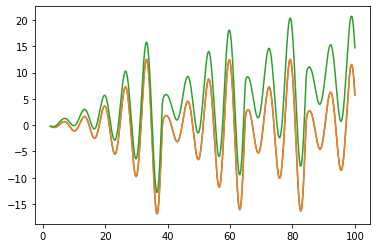

In [296]:
# COmpare trajectories next. 
# Order: Blue - true, orange - traj from true derivatives, green - traj from predictions
# BUT WHY IS ORANGE OFF???
# time_series = timme
traj_predr = integrate.cumtrapz( deriv, x=time_series, axis=1 ) + x0
traj_predp = integrate.cumtrapz( dxp, x=time_series, axis=1 ) + x0
plt.plot(time_series, np.vstack((traj[[ind]], np.hstack((x0, traj_predr))[[ind]], np.hstack((x0, traj_predp))[[ind]] )).T)

In [227]:
net_archive1 = net_listO[0] # (temp.ly) Stored here is the unnomalized model trained after 2900 epochs

1

In [525]:
# Alternate code if you want to specify your own embeddings
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'adam'
# opt_args = (0.005,) # Order: (Learning rate,)
activation = 'tanh' # 'leaky relu 0.2' # 'relu' # 'tanh'
output_activation = 'none'
log_root_dir = 'Fma_logs/'
input_masks = [ [4,7] ] # Reminder: index 0 is time. Index 1 is first state.
# input_masks = [ [4] ]
# input_masks = [[1,4]]
# input_masks = [[1,4,7]]
Nlayer = 2 #3
Nneuron = 10 #20
# tts = np.array([[60,120,180,240,300,360,420,0]])
# tts = np.array([[10,30,60,100,150,0]])
# tts = np.array([[60,120,180,240,300,0],
#                 [60,120,180,240,300,0],
#                 [40,80,120,160,200,0]])
tts = np.array([[60,120,180,240,300,0],
                [60,120,180,240,300,0]])
# tts = np.array([[33,77,111,154,177,0],
#                 [44,77,110,154,199,0]])
js,ts = delay_embed_converter_Garcia_Cao(False, tts)
de = 6
delay_int = 60

pred = 50

net_listM = []
# Add two more models that don't use symmetry
for i in range(len(sys_list)):
    net_listM.append(
        embed_dynamics.NN_FNN(
            sys_list[i], input_masks[i], ratio=10, stop_threshold=0, min_tau=100, max_tau=1000, max_de=10, verbose=True,
            fnn_ind=0, FNNtype='kennel', uniform_delay=False, inverse=True, 
            delay_vars=(js, ts, tts),
            seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, opt_args=opt_args, pred=pred
        ))
    net_listM.append(
        embed_dynamics.NN_Delay(
            sys_list[i], input_masks[i], seed=seed, log_dir=log_root_dir+sys_names[i], tensorboard=False,
            Nlayer=Nlayer, Nneuron=Nneuron, activation=activation, output_activation=output_activation, 
            optimizer=opt_alg, loss='mse', pred=pred, 
            de=de, delay_int=delay_int #, sym=True
        )
    )
# net_names = [ sys_names[i]+'-NN' for i in range(len(sys_list)) ]
net_names = ['FNN','delay']

Epoch = 100
# Construct models
for nn in net_listM:
    nn.construct()
    nn.train(epoch=Epoch, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Inputset size = (9650, 12, 1); outputset size = (9650, 7, 1)
Input set is masked by  [4, 7]
Train on 9650 samples
Epoch 1/100
9650/9650 [==============================] - 1s 114us/sample - loss: 0.4890
Epoch 2/100
9650/9650 [==============================] - 0s 49us/sample - loss: 0.3889
Epoch 3/100
9650/9650 [==============================] - 0s 45us/sample - loss: 0.3690
Epoch 4/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3581
Epoch 5/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3458
Epoch 6/100
9650/9650 [==============================] - 0s 37us/sample - loss: 0.3338
Epoch 7/100
9650/9650 [==============================] - 0s 38us/sample - loss: 0.3234
Epoch 8/100
9650/9650 [==============================] - 0s 43us/sample - loss: 0.3197
Epoch 9/100
9650/9650 [==============================] - 0s 42us/sample - loss: 0.3101
Epoch 10/100
9650/9650 [==============================] - 0s 41us/sample - loss: 0.3053
Epoch 11/100
9

/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  return data, params


Train on 9650 samples
Epoch 1/100
9650/9650 [==============================] - 1s 116us/sample - loss: 0.6854
Epoch 2/100
9650/9650 [==============================] - 0s 35us/sample - loss: 0.4612
Epoch 3/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.4301
Epoch 4/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.4126
Epoch 5/100
9650/9650 [==============================] - 0s 31us/sample - loss: 0.3998
Epoch 6/100
9650/9650 [==============================] - 0s 31us/sample - loss: 0.3898
Epoch 7/100
9650/9650 [==============================] - 0s 33us/sample - loss: 0.3822
Epoch 8/100
9650/9650 [==============================] - 0s 39us/sample - loss: 0.3760
Epoch 9/100
9650/9650 [==============================] - 0s 38us/sample - loss: 0.3709
Epoch 10/100
9650/9650 [==============================] - 0s 34us/sample - loss: 0.3668
Epoch 11/100
9650/9650 [==============================] - 0s 36us/sample - loss: 0.3633
Epoch 12/100
9650/

In [470]:
for nn in net_listM:
    nn.train(epoch=500, inds=[0]) # inds is the dataset selected for training
    nn.summary()

Train on 9650 samples
Epoch 1/500
9650/9650 [==============================] - 0s 45us/sample - loss: 0.0818
Epoch 2/500
9650/9650 [==============================] - 0s 47us/sample - loss: 0.0817
Epoch 3/500
9650/9650 [==============================] - 0s 43us/sample - loss: 0.0806
Epoch 4/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0809
Epoch 5/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0812
Epoch 6/500
9650/9650 [==============================] - 0s 39us/sample - loss: 0.0814
Epoch 7/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0815
Epoch 8/500
9650/9650 [==============================] - 0s 39us/sample - loss: 0.0811
Epoch 9/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0807
Epoch 10/500
9650/9650 [==============================] - 0s 41us/sample - loss: 0.0816
Epoch 11/500
9650/9650 [==============================] - 0s 40us/sample - loss: 0.0809
Epoch 12/500
9650/9

In [412]:
net_listM[0].input_norm_params[0]

array([ 0.0627191 ,  0.12057046,  0.18222496,  0.22761257,  0.24013908,
        0.21180435, -2.39350546, -2.1789588 , -1.97034745, -1.80156447,
       -1.70327746, -1.69752152])

In [417]:
net_listM[0].Inputset[0].shape
net_listM[0].pred

51

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


<Figure size 432x288 with 0 Axes>

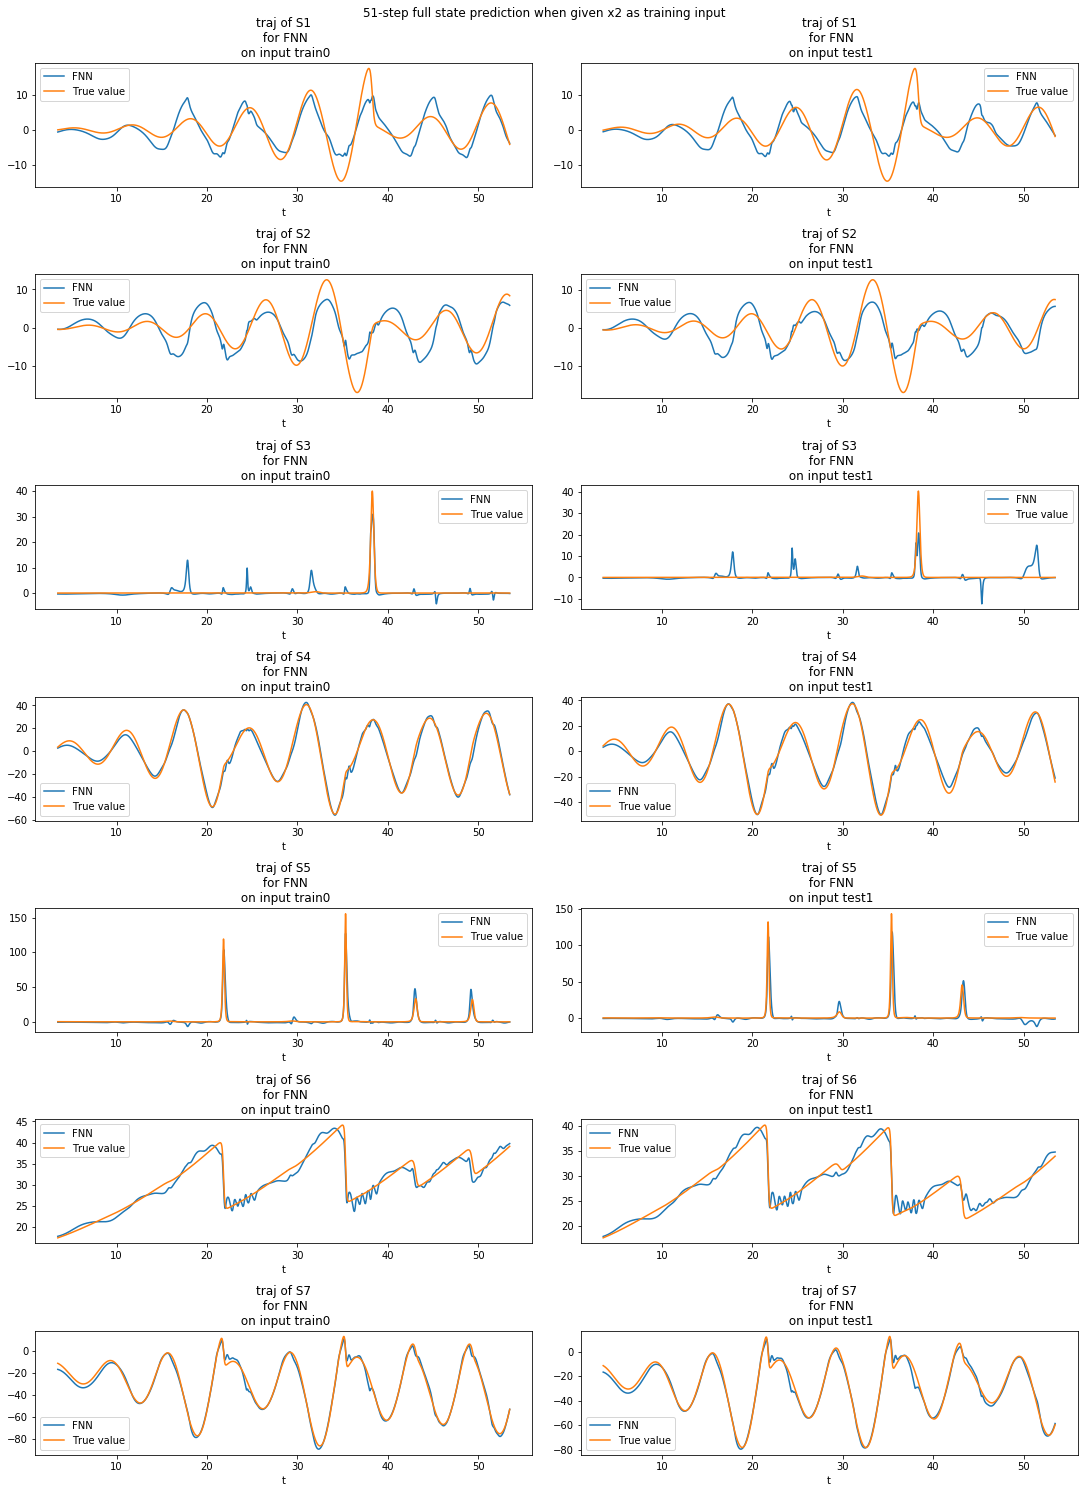

In [527]:
fig, axs, rlist = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=50/dt,
                       title='51-step full state prediction when given x2 as training input\n' )

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


/Users/zz/Documents/GT 20X/phml/NN_toy_examples/dynamics_methods.py:83: RuntimeWarning: invalid value encountered in true_divide
  return data, params


<Figure size 432x288 with 0 Axes>

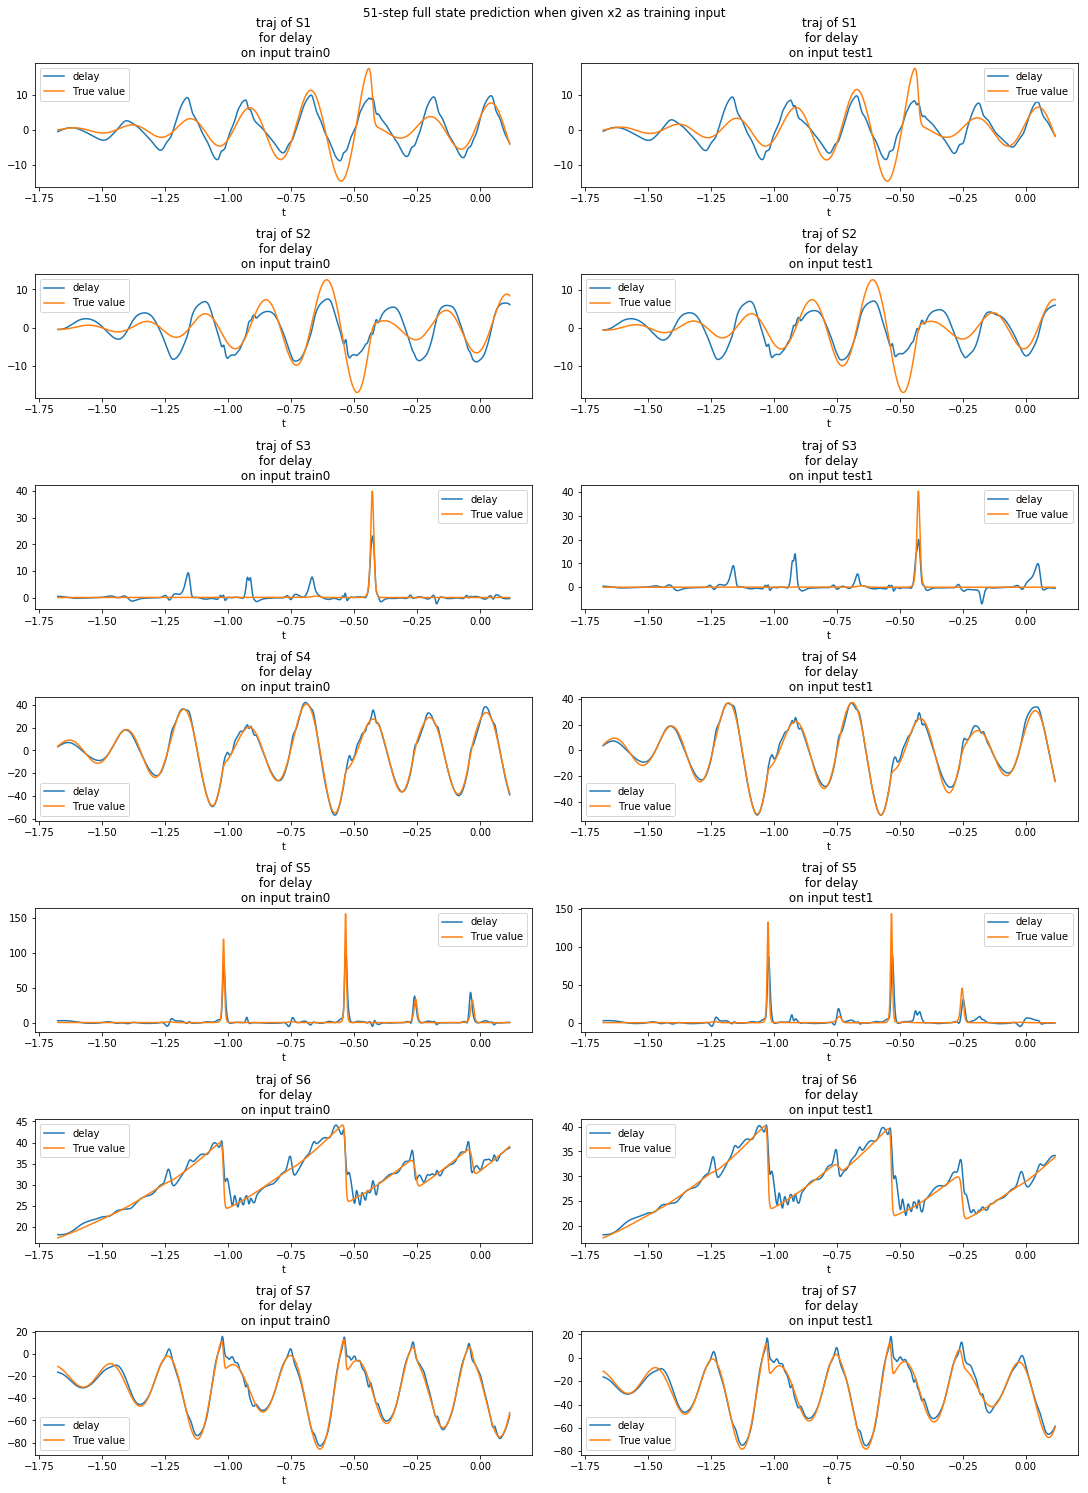

In [526]:
fig, axs, _ = plot_tests( test_inds=[0,1], net_list=net_listM, net_inds=[1], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=1, maxtime=50/dt,
                       title='51-step full state prediction when given x2 as training input\n' )

Dimensions: Outputset = (9650, 7, 1), results = (9650, 7, 1)


<Figure size 432x288 with 0 Axes>

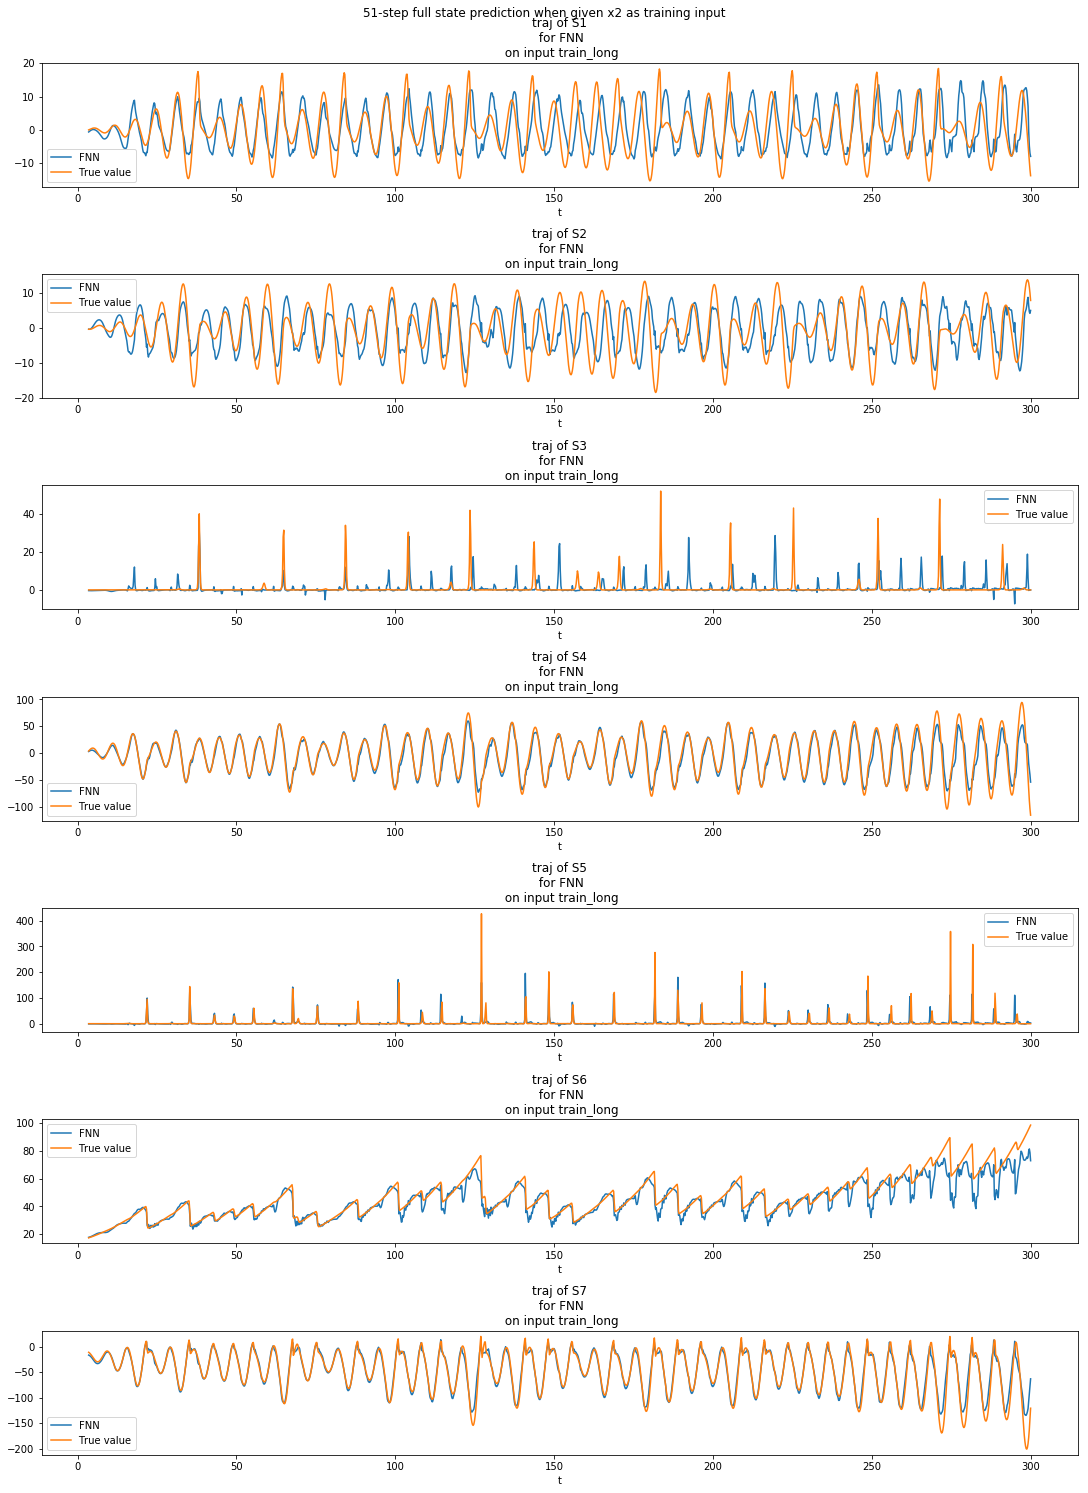

In [528]:
# Plots the test dataset with very long time range
fig, axs, _ = plot_tests( test_inds=[2], net_list=net_listM, net_inds=[0], out_list=[0,1,2,3,4,5,6], 
                       net_names=net_names, u_names=u_names, out_names=out_names,
                       datatype='traj', log_mode=False, plot_skip_rate=20,
                       title='51-step full state prediction when given x2 as training input\n' )